<a href="https://colab.research.google.com/github/ewotawa/udacity_pytorch_challenge/blob/master/Wotawa_Image_Classifier_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='https://github.com/udacity/pytorch_challenge/blob/master/assets/Flowers.png?raw=1' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# Imports here
# NOTE: I am using Google Colab to complete this project. I am accessing the images from my Google Drive (see note below). 

# configure inline backend:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Matplotlib Pyplot
import matplotlib.pyplot as plt

# PyTorch, torchvision
# PyTorch import syntax: https://colab.research.google.com/notebooks/snippets/importing_libraries.ipynb#scrollTo=n3joqGF1RTry&line=8&uniqifier=1
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

# PyTorch modules
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

# pillow
# deal with error message in reading images later in code. 
# https://stackoverflow.com/questions/48547660/attributeerror-module-pil-image-has-no-attribute-register-extensions
!pip install pillow==4.1.1
%reload_ext autoreload
%autoreload

# Install dependencies
!pip install PyDrive

# Import necessary libraries and methods
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Set up separate transforms, ImageFolders, and dataloaders for training and testing image sets. 
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

# visualize images to understand data augmentations
from torchvision import utils

# read in the JSON object, determine number of output features required
import json

# TODO: Save the checkpoint 
from google.colab import files

# Upload the file to Drive.
from googleapiclient.http import MediaFileUpload

# dependencies for process_image()
from PIL import Image


# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). You can [download the data here](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip). The dataset is split into two parts, training and validation. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. If you use a pre-trained network, you'll also need to make sure the input data is resized to 224x224 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each color channel was normalized separately. For both sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [2]:
# Note: I stored the image data in my Google Drive and used the following code (see reference) to access it remotely. 
# Note to reviewer: if you choose to use Google Drive also, you will need to update the file ID referenced in this cell and the next. The path ID corresponds to the http path displayed when you have the flower_data folder open in Google Drive.
# Note to reviewer: if you choose to use Google Drive also, you will need to authenticate access from Google Colab to Google Drive. Watch code output below this cell for more instructions.

# https://medium.freecodecamp.org/how-to-transfer-large-files-to-google-colab-and-remote-jupyter-notebooks-26ca252892fa

# Install dependencies
!pip install PyDrive

# Import necessary libraries and methods
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authorize Google SDK to access Google Drive from Colab
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Obtain file's ID
# https://drive.google.com/open?id=1255hmJ_bjLTVLO52JA7if_RGXdUgNZzk

In [0]:
# Transfer contents
# Note to reviewer: I converted flower_data.zip to flower_data.tar before uploading to Google Drive. 
download = drive.CreateFile({'id': '1255hmJ_bjLTVLO52JA7if_RGXdUgNZzk'})
download.GetContentFile('flower_data.tar')

In [4]:
# Show files in current directory
!pwd
!ls -a

/content
.  ..  adc.json  .config  flower_data.tar  home  pytorch_challenge  sample_data


In [5]:
# Unzip tar file
!tar -xvf flower_data.tar --directory /content/

home/ewotawa/Downloads/flower_data/
home/ewotawa/Downloads/flower_data/valid/
home/ewotawa/Downloads/flower_data/valid/25/
home/ewotawa/Downloads/flower_data/valid/25/image_06572.jpg
home/ewotawa/Downloads/flower_data/valid/25/image_06584.jpg
home/ewotawa/Downloads/flower_data/valid/24/
home/ewotawa/Downloads/flower_data/valid/24/image_06818.jpg
home/ewotawa/Downloads/flower_data/valid/24/image_06814.jpg
home/ewotawa/Downloads/flower_data/valid/24/image_06847.jpg
home/ewotawa/Downloads/flower_data/valid/24/image_06836.jpg
home/ewotawa/Downloads/flower_data/valid/24/image_06819.jpg
home/ewotawa/Downloads/flower_data/valid/76/
home/ewotawa/Downloads/flower_data/valid/76/image_02485.jpg
home/ewotawa/Downloads/flower_data/valid/76/image_02475.jpg
home/ewotawa/Downloads/flower_data/valid/76/image_02494.jpg
home/ewotawa/Downloads/flower_data/valid/76/image_02529.jpg
home/ewotawa/Downloads/flower_data/valid/76/image_02513.jpg
home/ewotawa/Downloads/flower_data/valid/76/image_02523.jpg
home/ew

In [6]:
# show detail after unpack tar file
# Note to reviewer: If you are executing code and using the Google Drive method, you will need to update the path in the os.chdir() below. 

import os
!pwd
!ls -a

os.chdir('home/ewotawa/Downloads/flower_data')

!pwd
!ls -a

/content
.  ..  adc.json  .config  flower_data.tar  home  pytorch_challenge  sample_data
/content/home/ewotawa/Downloads/flower_data
.  ..  train  valid


In [0]:
# instead of '/flower_data', point data_dir to active directory where images have been unpacked.

data_dir = os.getcwd()
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'

In [0]:
# Set up separate transforms, ImageFolders, and dataloaders for training and testing image sets. 

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np


# TODO: Define your transforms for the training and validation sets
data_transforms = {
    'train': transforms.Compose([transforms.RandomRotation(60),
                                       transforms.RandomResizedCrop(224), # size required by trained torchvision models
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomGrayscale(p=0.1),
                                       transforms.ToTensor(), # convert to tensor
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                      ]),
    'valid': transforms.Compose([transforms.Resize(255), # center image with window large enough to crop
                                      transforms.CenterCrop(224), # crop to size required by trained torchvision models
                                      transforms.ToTensor(), # convert to tensor
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                     ])
}
 

# TODO: Load the datasets with ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                 for x in ['train', 'valid']}

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

# TODO: Using the image datasets and the trainforms, define the dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=num_workers)
              for x in ['train', 'valid']}

# dataset sizes
dataset_sizes = {x: len(image_datasets[x])
                for x in ['train', 'valid']}

class_codes = image_datasets['train'].classes

# use the GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

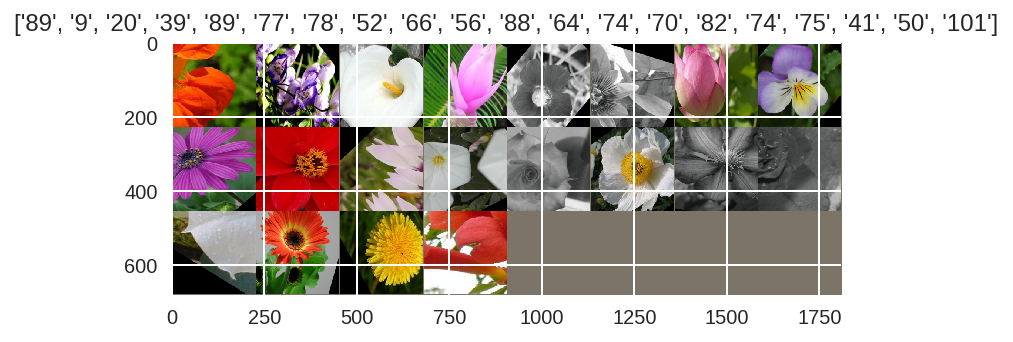

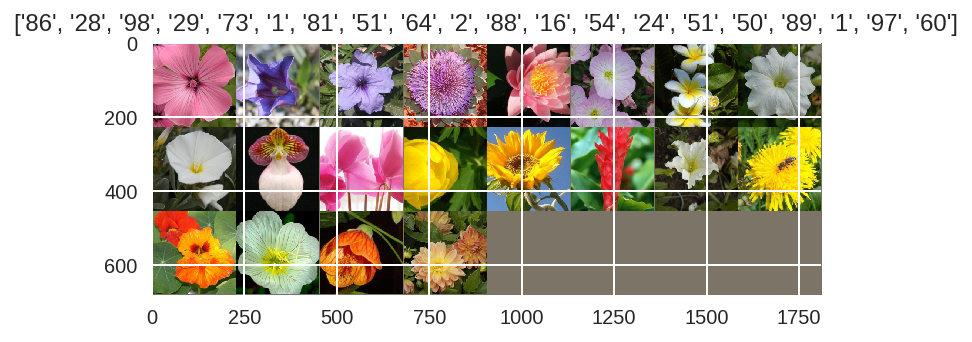

In [9]:
# visualize images to understand data augmentations
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

from torchvision import utils

def imshow(inp, title=None):
  # Imshow for tensor
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.pause(0.001) # pause so that plots are updated
  
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# make a grid from the batch
out = utils.make_grid(inputs)

imshow(out, title=[class_codes[x] for x in classes])

# Get a batch of validation data
v_inputs, v_classes = next(iter(dataloaders['valid']))

# make a grid from the batch
v_out = utils.make_grid(v_inputs)

imshow(v_out, title=[class_codes[x] for x in v_classes])

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [10]:
# Reset directory to for downloads

os.chdir('..')
os.chdir('..')
os.chdir('..')
os.chdir('..')

!pwd
!ls -a

# Download pytorch challenge and navigate to folder containing pytorch_challenge

!git clone https://github.com/udacity/pytorch_challenge
  
!ls -a

os.chdir('pytorch_challenge')

!ls -a

/content
.  ..  adc.json  .config  flower_data.tar  home  pytorch_challenge  sample_data
fatal: destination path 'pytorch_challenge' already exists and is not an empty directory.
.  ..  adc.json  .config  flower_data.tar  home  pytorch_challenge  sample_data
 .    assets		 flower_data.tar  'Image Classifier Project.ipynb'
 ..   cat_to_name.json	 .git		   trained_vgg16_classifier.pth


In [11]:
# read in the JSON object, determine number of output features required

import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
    
print(cat_to_name)
print(len(cat_to_name))

output_len = len(cat_to_name)

{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved pocket orchid', '54': 's

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [12]:
# load and define a pre-trained network

model = models.vgg16(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:38<00:00, 14380765.06it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [13]:
# freeze parameters to prevent backpropagation

for param in model.parameters():
  param.requires_grad = False

# Define a new, untrained feed-forward network as a classifier, using the ReLU activations and dropout

n_input = 25088 # same as input for classifier provided 
n_output = len(cat_to_name) # number of output features matches number of flower classes

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                                        ('fc1', nn.Linear(n_input, 500)),
                                        ('relu1', nn.ReLU()),
                                        ('dropout1', nn.Dropout(p=0.2)),
                                        ('fc2', nn.Linear(500, n_output)),
                                        ('output', nn.LogSoftmax(dim=1))
                                      ]))

model.classifier = classifier
print(model.classifier)

# define loss criterion and optimizer. Only train classifier parameters. Feature parameters are frozen
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

model.to(device);


Sequential(
  (fc1): Linear(in_features=25088, out_features=500, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.2)
  (fc2): Linear(in_features=500, out_features=102, bias=True)
  (output): LogSoftmax()
)


In [14]:
# Train the classifier layers using backpropagation using the pre-trained network to get the features
# Track the loss and accuracy on the validation set to determine the best hyperparameters

# define epochs, steps, and running loss
# define training and validation passes, calculate accuracy

epochs = 3
steps = 0
print_every = 5

train_losses, valid_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in dataloaders['train']:
      
      # update the step counter
      steps += 1
      
      # move images and label tensors to device
      images, labels = images.to(device), labels.to(device)
      
      # clear gradients in the optimizer
      optimizer.zero_grad()
      
      log_ps = model.forward(images)
      loss = criterion(log_ps, labels)
      loss.backward()
      optimizer.step()
      
      running_loss += loss.item()
      
      # add language to print every fifth step
      
      if steps % print_every == 0:
        
        # implement the validation pass and print out validation accuracy
        valid_loss = 0
        accuracy = 0
        
        # put model in evaluation mode
        model.eval()
        
        # turn off gradients
        with torch.no_grad():
          for images, labels in dataloaders['valid']:
            
            # move image and label tensors to device
            images, labels = images.to(device), labels.to(device)
            
            # calculate model results and loss
            log_ps = model.forward(images)
            batch_loss = criterion(log_ps, labels)
            
            valid_loss += batch_loss.item()
            
            # get the class probabilities
            ps = torch.exp(log_ps)
            
            # use top-k to identify most likely classes
            top_p, top_class = ps.topk(1, dim=1)
            
            # compare to true labels
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
          train_losses.append(running_loss/len(dataloaders['train']))
          valid_losses.append(valid_loss/len(dataloaders['valid']))
        
        print('Epoch: {}/{} ..'.format(e+1, epochs),
              'Training loss: {:.3f} ..'.format(running_loss/len(dataloaders['train'])),
              'Testing (Validation) loss: {:.3f} ..'.format(valid_loss/len(dataloaders['valid'])),
              'Accuracy: {:.3f} ..'.format(accuracy/len(dataloaders['valid']))
             )

        running_loss = 0

        model.train()

Epoch: 1/3 .. Training loss: 0.081 .. Testing (Validation) loss: 5.544 .. Accuracy: 0.055 ..
Epoch: 1/3 .. Training loss: 0.086 .. Testing (Validation) loss: 4.563 .. Accuracy: 0.130 ..
Epoch: 1/3 .. Training loss: 0.066 .. Testing (Validation) loss: 4.257 .. Accuracy: 0.143 ..
Epoch: 1/3 .. Training loss: 0.068 .. Testing (Validation) loss: 4.072 .. Accuracy: 0.154 ..
Epoch: 1/3 .. Training loss: 0.064 .. Testing (Validation) loss: 3.837 .. Accuracy: 0.233 ..
Epoch: 1/3 .. Training loss: 0.063 .. Testing (Validation) loss: 3.741 .. Accuracy: 0.238 ..
Epoch: 1/3 .. Training loss: 0.061 .. Testing (Validation) loss: 3.583 .. Accuracy: 0.242 ..
Epoch: 1/3 .. Training loss: 0.059 .. Testing (Validation) loss: 3.455 .. Accuracy: 0.262 ..
Epoch: 1/3 .. Training loss: 0.060 .. Testing (Validation) loss: 3.354 .. Accuracy: 0.293 ..
Epoch: 1/3 .. Training loss: 0.060 .. Testing (Validation) loss: 3.226 .. Accuracy: 0.315 ..
Epoch: 1/3 .. Training loss: 0.056 .. Testing (Validation) loss: 3.112

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [15]:
# TODO: Save the checkpoint 

from google.colab import files

# https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-a-general-checkpoint-for-inference-and-or-resuming-training
# https://pytorchfbchallenge.slack.com/archives/CE24506TF/p1546152769887500?thread_ts=1546150714.879800&cid=CE24506TF

# print the model's state dict:
print("Model's state_dict:")
for param_tensor in model.state_dict():
  print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# print the optimizer's state dict:
#print("Optimizer's state_dict:")
#for var_name in optimizer.state_dict():
  #print(var_name, "\t", optimizer.state_dict()[var_name])

# print the classifier:
print("Classifier:")
for param_tensor in model.classifier:
  print(param_tensor in model.classifier)
  
# print the class to index:
model.class_to_idx = image_datasets['train'].class_to_idx
print("Class to index:")
print(model.class_to_idx)

torch.save({
    'model_state_dict': model.state_dict(),
    'classifier': model.classifier,
    'class_to_idx': model.class_to_idx
}, 'trained_vgg16_classifier.pt')

Model's state_dict:
features.0.weight 	 torch.Size([64, 3, 3, 3])
features.0.bias 	 torch.Size([64])
features.2.weight 	 torch.Size([64, 64, 3, 3])
features.2.bias 	 torch.Size([64])
features.5.weight 	 torch.Size([128, 64, 3, 3])
features.5.bias 	 torch.Size([128])
features.7.weight 	 torch.Size([128, 128, 3, 3])
features.7.bias 	 torch.Size([128])
features.10.weight 	 torch.Size([256, 128, 3, 3])
features.10.bias 	 torch.Size([256])
features.12.weight 	 torch.Size([256, 256, 3, 3])
features.12.bias 	 torch.Size([256])
features.14.weight 	 torch.Size([256, 256, 3, 3])
features.14.bias 	 torch.Size([256])
features.17.weight 	 torch.Size([512, 256, 3, 3])
features.17.bias 	 torch.Size([512])
features.19.weight 	 torch.Size([512, 512, 3, 3])
features.19.bias 	 torch.Size([512])
features.21.weight 	 torch.Size([512, 512, 3, 3])
features.21.bias 	 torch.Size([512])
features.24.weight 	 torch.Size([512, 512, 3, 3])
features.24.bias 	 torch.Size([512])
features.26.weight 	 torch.Size([512, 5

In [21]:
# https://pytorchfbchallenge.slack.com/archives/CE24506TF/p1546304217775400?thread_ts=1546145768.866100&cid=CE24506TF

# Notebook is encountering exceptions when executing the code below. To work around issue I manually downloaded the model from the colab directory.

files.download('trained_vgg16_classifier.pt')

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 50718, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 721, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

In [14]:
files.upload()

Saving trained_vgg16_classifier.pth to trained_vgg16_classifier.pth


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [19]:
!pwd
!ls -l

check_name = 'trained_vgg16_classifier.pt'
check_path = os.getcwd()
check_load = check_path + '/' + check_name

print(check_load)

/content/pytorch_challenge
total 442676
drwxr-xr-x 2 root root      4096 Jan  1 00:30  assets
-rw-r--r-- 1 root root      2218 Jan  1 00:30  cat_to_name.json
-rw-r--r-- 1 root root 317501440 Jan  1 00:59  flower_data.tar
-rw-r--r-- 1 root root     16353 Jan  1 00:30 'Image Classifier Project.ipynb'
-rw-r--r-- 1 root root 109257417 Jan  1 03:23  trained_vgg16_classifier.pt
-rw-r--r-- 1 root root  26513136 Jan  1 00:33  trained_vgg16_classifier.pth
/content/pytorch_challenge/trained_vgg16_classifier.pt


In [0]:
# TODO: Write a function that loads a checkpoint and rebuilds the model

# https://discuss.pytorch.org/t/loading-a-saved-model-for-continue-training/17244/3
# https://pytorchfbchallenge.slack.com/archives/CE24506TF/p1546152769887500?thread_ts=1546150714.879800&cid=CE24506TF

def load_vgg_checkpoint(filename):
  checkpoint = torch.load(filename, map_location=lambda storage, loc: storage)
  model = models.vgg16(pretrained=True)
  model.classifier = checkpoint['classifier']
  model.state_dict = checkpoint['model_state_dict']
  class_to_idx = checkpoint['class_to_idx']
    
  return model, model.classifier, class_to_idx



In [21]:
# test function load_vgg_checkpoint()

filename=check_load

model, model.classifier, class_to_idx = load_vgg_checkpoint(filename)

print(model)
print(model.classifier)
print(class_to_idx)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [22]:
# obtain an image for testing process_image

os.chdir(valid_dir)
# !ls -a
os.chdir('1')
# !ls -a
    
test_image = valid_dir + '/1/image_06739.jpg'
    
print(test_image)

/content/home/ewotawa/Downloads/flower_data/valid/1/image_06739.jpg


In [0]:
from PIL import Image

def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    
    # load the image
    im = Image.open(image)
    # print(im)
    
    # resize images where shortest size is 256 pixels, keeping aspect ratio. 
    orig_dim = im.size
    orig_x = orig_dim[0]
    orig_y = orig_dim[1]
    
    new_min_dim = 256
    
    if orig_x < orig_y:
      new_x = new_min_dim
      new_y = orig_y * new_x / orig_x
    else:
      new_y = new_min_dim
      new_x = orig_x * new_y / orig_y
      
    new_size = (new_x, new_y)
    
    im.thumbnail(new_size)
    # print(im)
    
    # crop the center 224 x 224
    # https://stackoverflow.com/questions/7735554/cropping-image-image-crop-function-not-working
    # https://stackoverflow.com/questions/16646183/crop-an-image-in-the-centre-using-pil
    crop_dim = 224
    
    left = (new_x - crop_dim) / 2
    right = (new_x + crop_dim) / 2
    top = (new_y - crop_dim) / 2
    bottom = (new_y + crop_dim) / 2
    
    crop_tuple = (left, top, right, bottom)
    # print(crop_tuple)
    
    crop_im = im.crop(crop_tuple)
    # print(crop_im)
    
    # convert color channel values from integers (0-255) to floats (0-1). 
    inp = np.array(crop_im, dtype=float)
    dt = inp.dtype
    # print(dt)
    
    # normalize the images.
    # https://stackoverflow.com/questions/47124143/mean-value-of-each-channel-of-several-images
    mean = np.mean(inp, axis=tuple(range(inp.ndim-1)))
    # print(mean)
    std = np.std(inp, axis=tuple(range(inp.ndim-1)))
    # print(std)
    inp = (inp - mean) / std
    
    # transpose array such that color channel is moved from third dimesion to first, all other orders same. 
    inp = inp.transpose((2, 0, 1))
    
    image = torch.from_numpy(inp)
    
    return image

In [24]:
# see what the process_image function does.

# Get a batch of validation data
image = process_image(test_image)

image.shape

torch.Size([3, 224, 224])

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [0]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax
  

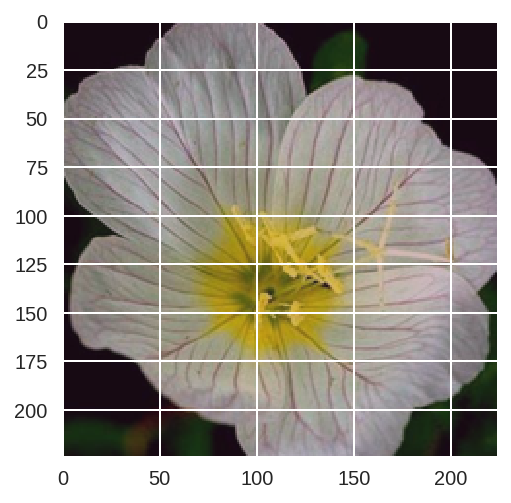

In [26]:
imshow(image)

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [0]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    
    # convert the image to the format the model can read
    image = process_image(image_path)
    
    model.eval()

    # move model inputs to cuda, if GPU available
    if train_on_gpu:
        image = image.cuda()
        model = model.cuda()

    # Get the class probabilities
    with torch.no_grad():
      ps = torch.exp(model(images[0].unsqueeze(0)))
    # Make sure the shape is appropriate, we should get 10 class probabilities for 64 examples
    # print(ps.shape)

    top_p, top_class = ps.topk(5, dim=1)
    # Look at the most likely classes for the first 10 examples
    probs = top_p.cpu().numpy().squeeze()
    classes = top_class.cpu().numpy().squeeze()

    

    return probs, classes

In [28]:
probs, classes = predict(test_image, model, topk=5)

print(probs)
print(classes)

[9.9998188e-01 8.8310499e-06 2.8723780e-06 2.4550764e-06 2.1555647e-06]
[75 88 76 67 15]


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the validation accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='https://github.com/udacity/pytorch_challenge/blob/master/assets/inference_example.png?raw=1' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [0]:
# TODO: Display an image along with the top 5 classes

In [29]:
print(cat_to_name)
print(cat_to_name['21'])

strings, flowers = [], []

for i in classes:
  strings.append(str(i))
  
for i in strings:
  flowers.append(cat_to_name[i])
  
print(strings)
print(flowers)
  


{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved pocket orchid', '54': 's

In [0]:
# https://matplotlib.org/gallery/lines_bars_and_markers/barh.html
def view_classify(probs, classes, flowers):
    ''' Function for viewing an image and it's predicted classes.
    '''
    fig, ax = plt.subplots()
    y_pos = np.arange(len(flowers))
    
    ax.barh(y_pos, probs)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(flowers, size='large')
    
    ax.set_title('Class Probability for top 5 classes')
    
    plt.tight_layout()

hibiscus


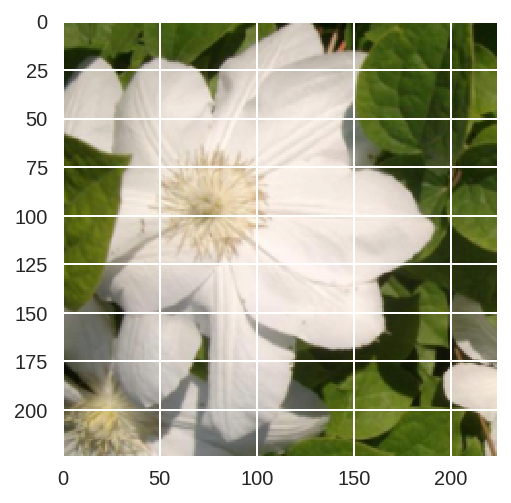

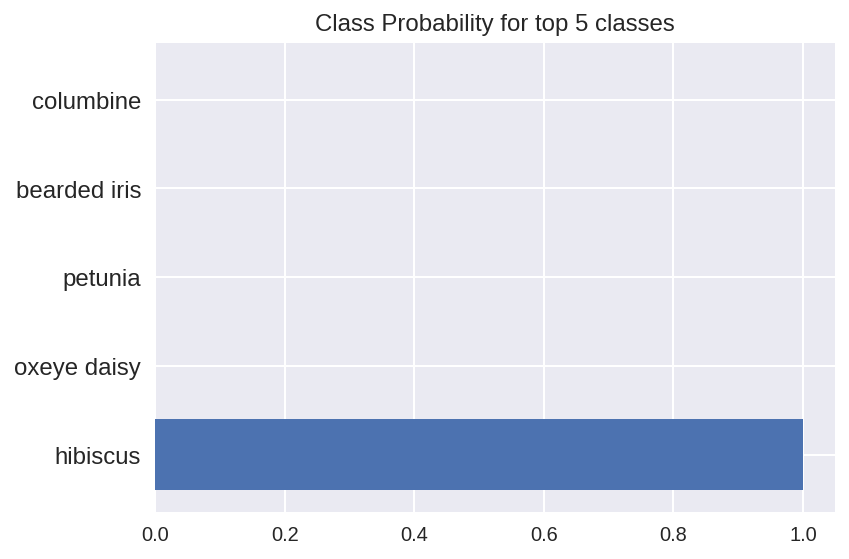

In [34]:
# https://pytorchfbchallenge.slack.com/archives/CE24506TF/p1546141785860700

# obtain one batch of test images
dataiter = iter(dataloaders['valid'])
images, labels = dataiter.next()
images.numpy()

model.eval()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()
    labels = labels.cuda()
    model = model.cuda()

# Get the class probabilities
with torch.no_grad():
  ps = torch.exp(model(images[0].unsqueeze(0)))
# Make sure the shape is appropriate, we should get 10 class probabilities for 64 examples
# print(ps.shape)

top_p, top_class = ps.topk(5, dim=1)
# Look at the most likely classes for the first 10 examples
ps = top_p.cpu().numpy().squeeze()
cs = top_class.cpu().numpy().squeeze()

strings, flowers = [], []

for i in cs:
  strings.append(str(i))
  
for i in strings:
  flowers.append(cat_to_name[i])
  
# print(ps)
# print(cs)
# print(strings)
# print(flowers)

label_str = str(labels[0].cpu().numpy())

print(cat_to_name[label_str])
imshow(images[0].cpu())
view_classify(probs, classes, flowers)